# MATCH2BRAIN -- Best Intact Layer

## Import packages

In [1]:
save = True

In [2]:
#import packages
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import json

In [3]:
# import from other scripts
import plot_utils
import stats_utils
from plot_utils import *

## Define approach configuration

In [4]:
model_identifier="gpt2-xl"

In [5]:
#whether or not to include control condition random nouns (used for SI)
randomnouns=False
length_control=False

In [6]:
#load configuration
with open('configurations.json', 'r') as f:
    config = json.load(f)
    
list(config.keys())

['TrainIntact-TestPerturbed:contextualized',
 'TrainIntact-TestPerturbed:decontextualized',
 'TrainPerturbed-TestPerturbed:contextualized',
 'TrainPerturbed-TestPerturbed:decontextualized',
 'TrainPerturbed-TestPerturbed:cv-by-passage']

In [7]:
# get setting
approach = "TrainIntact-TestPerturbed:contextualized" #main is "TrainIntact-TestPerturbed:contextualized"

emb_context=config[approach]["emb_context"]
split_coord=config[approach]["split_coord"]
testonperturbed=config[approach]["testonperturbed"]

In [8]:
import os, sys
import re
import pickle
import numpy as np
import pandas as pd

best_layer = get_best_scores_df(model_identifier=model_identifier,
                                  emb_context=emb_context,
                                  split_coord=split_coord,
                                  testonperturbed=testonperturbed,
                                  randomnouns=randomnouns,
                                  length_control=length_control,
                                  nr_of_splits=5,
                                  which_df = 'plot',
                                 return_best_layer=True,
                                 return_best_layer_score=False,
                                 best_layer=None)

print(best_layer)

scores_df = get_best_scores_df(model_identifier=model_identifier,
                                 emb_context=emb_context,
                                 split_coord=split_coord,
                                 testonperturbed=testonperturbed,
                                 randomnouns=randomnouns,
                                 length_control=length_control,
                                 which_df = 'plot',
                                 return_best_layer=False,
                                 return_best_layer_score=True,
                                 best_layer=best_layer)

scores_df

encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44
encoder.h.44


,score,error,condition,category,category_group
0,0.352717,0.014224,original,original,word-order
1,0.324739,0.017821,scrambled1,word-order,word-order
2,0.273509,0.010196,scrambled3,word-order,word-order
3,0.265913,0.006893,scrambled5,word-order,word-order
4,0.254448,0.020467,scrambled7,word-order,word-order
5,0.191823,0.020077,backward,word-order,word-order
6,0.261410,0.013420,lowpmi,word-order,word-order
7,0.237717,0.009657,lowpmi-random,word-order,word-order
8,0.006957,0.034716,random-wl,control,word-order
9,0.352717,0.010493,original,original,information-loss


## Get stimuli

In [9]:
stimuli_df = plot_utils.get_sample_stimuli(randomnouns=randomnouns,length_control=length_control)
stimuli_df

Original | original
Loading lookup from /om2/user/ckauf/anaconda39/envs/perturbed3.8/lib/python3.8/site-packages/brainio_collection/lookup.csv
/net/vast-storage.ib.cluster/scratch/vast/cpl/ckauf/perturbed-neural-nlp/neural_nlp/../ressources/stimuli
Scr1 | scrambled1
Scr3 | scrambled3
Scr5 | scrambled5
Scr7 | scrambled7
backward | backward
lowPMI | lowpmi
lowPMI_random | lowpmi-random
contentwords | contentwords
nounsverbsadj | nounsverbsadj
nounsverbs | nounsverbs
nouns | nouns
functionwords | functionwords
chatGPT | chatgpt
sentenceshuffle-withinpassage | sent_passage
sentenceshuffle-withintopic | sent_topic
sentenceshuffle-random | sent_random
random | random-wl


,condition,stimulus
0,original,beekeeping encourages the conservation of loca...
1,scrambled1,beekeeping encourages the conservation of habi...
2,scrambled3,beekeeping conservation encourages the of habi...
3,scrambled5,conservation beekeeping encourages the habitat...
4,scrambled7,beekeeping conservation of encourages habitats...
5,backward,habitats local of conservation the encourages ...
6,lowpmi,beekeeping conservation habitats the of encour...
7,lowpmi-random,encourages the beekeeping of habitats conserva...
8,contentwords,beekeeping encourages conservation local habit...
9,nounsverbsadj,beekeeping encourages conservation local habit...


### merge with stimuli df

In [10]:
full_df = scores_df.copy(deep=True)
for ind in full_df.index.values:
    cond = full_df.iloc[ind]['condition']
    stimulus = stimuli_df.loc[stimuli_df['condition'] == cond]['stimulus'].item()
    full_df.loc[ind, 'stimulus'] = stimulus
full_df

,score,error,condition,category,category_group,stimulus
0,0.352717,0.014224,original,original,word-order,beekeeping encourages the conservation of loca...
1,0.324739,0.017821,scrambled1,word-order,word-order,beekeeping encourages the conservation of habi...
2,0.273509,0.010196,scrambled3,word-order,word-order,beekeeping conservation encourages the of habi...
3,0.265913,0.006893,scrambled5,word-order,word-order,conservation beekeeping encourages the habitat...
4,0.254448,0.020467,scrambled7,word-order,word-order,beekeeping conservation of encourages habitats...
5,0.191823,0.020077,backward,word-order,word-order,habitats local of conservation the encourages ...
6,0.261410,0.013420,lowpmi,word-order,word-order,beekeeping conservation habitats the of encour...
7,0.237717,0.009657,lowpmi-random,word-order,word-order,encourages the beekeeping of habitats conserva...
8,0.006957,0.034716,random-wl,control,word-order,three climb around the the spears vapor.
9,0.352717,0.010493,original,original,information-loss,beekeeping encourages the conservation of loca...


In [11]:
#Rename conditions according to new names:
full_df['condition'] = full_df['condition'].map(plot_utils.COND2LABEL)

In [12]:
full_df["labelname"] = [': '.join(i) for i in zip(full_df["condition"].map(str),full_df["stimulus"])]
full_df

,score,error,condition,category,category_group,stimulus,labelname
0,0.352717,0.014224,Original,original,word-order,beekeeping encourages the conservation of loca...,Original: beekeeping encourages the conservati...
1,0.324739,0.017821,1LocalWordSwap,word-order,word-order,beekeeping encourages the conservation of habi...,1LocalWordSwap: beekeeping encourages the cons...
2,0.273509,0.010196,3LocalWordSwaps,word-order,word-order,beekeeping conservation encourages the of habi...,3LocalWordSwaps: beekeeping conservation encou...
3,0.265913,0.006893,5LocalWordSwaps,word-order,word-order,conservation beekeeping encourages the habitat...,5LocalWordSwaps: conservation beekeeping encou...
4,0.254448,0.020467,7LocalWordSwaps,word-order,word-order,beekeeping conservation of encourages habitats...,7LocalWordSwaps: beekeeping conservation of en...
5,0.191823,0.020077,ReverseOrder,word-order,word-order,habitats local of conservation the encourages ...,ReverseOrder: habitats local of conservation t...
6,0.261410,0.013420,LowPMI,word-order,word-order,beekeeping conservation habitats the of encour...,LowPMI: beekeeping conservation habitats the o...
7,0.237717,0.009657,LowPMIRand,word-order,word-order,encourages the beekeeping of habitats conserva...,LowPMIRand: encourages the beekeeping of habit...
8,0.006957,0.034716,RandWordList,control,word-order,three climb around the the spears vapor.,RandWordList: three climb around the the spear...
9,0.352717,0.010493,Original,original,information-loss,beekeeping encourages the conservation of loca...,Original: beekeeping encourages the conservati...


## Get stats

In [13]:
frames = []
for category in ["word-order", "information-loss", "semantic-distance"]:
    stats_df = stats_utils.get_ttest_results(model_identifier=model_identifier,
                      emb_context=emb_context,
                      split_coord=split_coord,
                      testonperturbed=testonperturbed,
                      category=category, randomnouns=randomnouns)
    frames.append(stats_df)
full_stats_df = pd.concat(frames)

full_stats_df

,condition,ttest2original,ttest2random,adjusted_pvals2original,adjusted_pvals2random,cohensd2original,cohensd2random,significance2original,significance2random,pvals2original,pvals2random
0,scrambled1,5.516605,-18.326904,2.604779e-03,1.371444e-07,0.571672,-8.288052,**,***,3.721113e-04,1.959206e-08
1,scrambled3,5.814307,-17.437331,1.784078e-03,2.122332e-07,1.527273,-9.486557,**,***,2.548683e-04,3.031903e-08
2,scrambled5,6.506588,-17.103954,7.742035e-04,2.513360e-07,1.629851,-9.322215,***,***,1.106005e-04,3.590515e-08
3,scrambled7,6.781450,-16.789871,5.650804e-04,2.955935e-07,1.640556,-9.229584,***,***,8.072578e-05,4.222765e-08
4,backward,9.284902,-15.265252,4.628364e-05,6.780925e-07,2.383474,-8.060254,***,***,6.611949e-06,9.687036e-08
5,lowpmi,6.354275,-20.505218,9.254445e-04,5.099831e-08,1.559693,-9.993554,***,***,1.322064e-04,7.285473e-09
6,lowpmi-random,8.467018,-17.035428,9.819869e-05,2.603265e-07,2.043047,-8.541678,***,***,1.402838e-05,3.718950e-08
0,contentwords,9.209139,-19.649411,3.536288e-05,5.305786e-08,1.855161,-7.140986,***,***,7.072576e-06,1.061157e-08
1,nounsverbsadj,12.824717,-16.825546,2.181338e-06,2.072543e-07,1.976862,-6.616886,***,***,4.362676e-07,4.145085e-08
2,nounsverbs,17.943714,-16.810956,1.179342e-07,2.088331e-07,2.696627,-6.942270,***,***,2.358685e-08,4.176662e-08


In [14]:
#Rename conditions according to new names:
full_stats_df['condition'] = full_stats_df['condition'].map(plot_utils.COND2LABEL)
full_stats_df

,condition,ttest2original,ttest2random,adjusted_pvals2original,adjusted_pvals2random,cohensd2original,cohensd2random,significance2original,significance2random,pvals2original,pvals2random
0,1LocalWordSwap,5.516605,-18.326904,2.604779e-03,1.371444e-07,0.571672,-8.288052,**,***,3.721113e-04,1.959206e-08
1,3LocalWordSwaps,5.814307,-17.437331,1.784078e-03,2.122332e-07,1.527273,-9.486557,**,***,2.548683e-04,3.031903e-08
2,5LocalWordSwaps,6.506588,-17.103954,7.742035e-04,2.513360e-07,1.629851,-9.322215,***,***,1.106005e-04,3.590515e-08
3,7LocalWordSwaps,6.781450,-16.789871,5.650804e-04,2.955935e-07,1.640556,-9.229584,***,***,8.072578e-05,4.222765e-08
4,ReverseOrder,9.284902,-15.265252,4.628364e-05,6.780925e-07,2.383474,-8.060254,***,***,6.611949e-06,9.687036e-08
5,LowPMI,6.354275,-20.505218,9.254445e-04,5.099831e-08,1.559693,-9.993554,***,***,1.322064e-04,7.285473e-09
6,LowPMIRand,8.467018,-17.035428,9.819869e-05,2.603265e-07,2.043047,-8.541678,***,***,1.402838e-05,3.718950e-08
0,KeepContentW,9.209139,-19.649411,3.536288e-05,5.305786e-08,1.855161,-7.140986,***,***,7.072576e-06,1.061157e-08
1,KeepNVAdj,12.824717,-16.825546,2.181338e-06,2.072543e-07,1.976862,-6.616886,***,***,4.362676e-07,4.145085e-08
2,KeepNV,17.943714,-16.810956,1.179342e-07,2.088331e-07,2.696627,-6.942270,***,***,2.358685e-08,4.176662e-08


In [15]:
if save and length_control:
    full_stats_df.to_csv(f"results_paper_revision/SupplementaryInformation/stats_{approach}_length_control.csv",index=False)

In [16]:
test = full_stats_df[['condition', 'ttest2original', 'adjusted_pvals2original', 'cohensd2original']].T
test, test.columns = test[1:] , test.iloc[0]
test

condition,1LocalWordSwap,3LocalWordSwaps,5LocalWordSwaps,7LocalWordSwaps,ReverseOrder,LowPMI,LowPMIRand,KeepContentW,KeepNVAdj,KeepNV,KeepN,KeepFunctionW,Paraphrase,RandSentFromPassage,RandSentFromTopic,RandSent
ttest2original,5.51661,5.81431,6.50659,6.78145,9.2849,6.35427,8.46702,9.20914,12.8247,17.9437,28.5825,17.4004,10.7815,6.84313,28.3473,24.2618
adjusted_pvals2original,0.00260478,0.00178408,0.000774204,0.00056508,4.62836e-05,0.000925444,9.81987e-05,3.53629e-05,2.18134e-06,1.17934e-07,1.9119e-09,1.54435e-07,7.62508e-06,0.000301245,1.6464e-09,6.57141e-09
cohensd2original,0.571672,1.52727,1.62985,1.64056,2.38347,1.55969,2.04305,1.85516,1.97686,2.69663,4.84229,9.86622,1.23785,0.975303,7.50152,11.8489


In [17]:
stats2original = full_stats_df[['condition', 'ttest2original', 'adjusted_pvals2original', 'cohensd2original']]

In [18]:
full_stats_df[['condition', 'ttest2random', 'adjusted_pvals2random', 'cohensd2random']]

,condition,ttest2random,adjusted_pvals2random,cohensd2random
0,1LocalWordSwap,-18.326904,1.371444e-07,-8.288052
1,3LocalWordSwaps,-17.437331,2.122332e-07,-9.486557
2,5LocalWordSwaps,-17.103954,2.513360e-07,-9.322215
3,7LocalWordSwaps,-16.789871,2.955935e-07,-9.229584
4,ReverseOrder,-15.265252,6.780925e-07,-8.060254
5,LowPMI,-20.505218,5.099831e-08,-9.993554
6,LowPMIRand,-17.035428,2.603265e-07,-8.541678
0,KeepContentW,-19.649411,5.305786e-08,-7.140986
1,KeepNVAdj,-16.825546,2.072543e-07,-6.616886
2,KeepNV,-16.810956,2.088331e-07,-6.942270


## Plot

In [19]:
#define global figure settings
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [20]:
#define colors
CAT2COLOR = {
    "original": "dimgray",
    #
    "word-order": sns.cubehelix_palette(7, start=.2, rot=-.25, dark=0.2, light=.9, reverse=True),
    "information-loss": sns.cubehelix_palette(5, start=2, rot=0, dark=0.2, light=.85, reverse=True),
    #cut off as last gradient color is similar across colors
    "semantic-distance": sns.light_palette("maroon", 5, reverse=True)[:4],
    #
    "control": "lightgray"
}

if randomnouns:
    CAT2COLOR["information-loss"] = sns.cubehelix_palette(6, start=2, rot=0, dark=0.2, light=.85, reverse=True)

In [21]:
full_df

,score,error,condition,category,category_group,stimulus,labelname
0,0.352717,0.014224,Original,original,word-order,beekeeping encourages the conservation of loca...,Original: beekeeping encourages the conservati...
1,0.324739,0.017821,1LocalWordSwap,word-order,word-order,beekeeping encourages the conservation of habi...,1LocalWordSwap: beekeeping encourages the cons...
2,0.273509,0.010196,3LocalWordSwaps,word-order,word-order,beekeeping conservation encourages the of habi...,3LocalWordSwaps: beekeeping conservation encou...
3,0.265913,0.006893,5LocalWordSwaps,word-order,word-order,conservation beekeeping encourages the habitat...,5LocalWordSwaps: conservation beekeeping encou...
4,0.254448,0.020467,7LocalWordSwaps,word-order,word-order,beekeeping conservation of encourages habitats...,7LocalWordSwaps: beekeeping conservation of en...
5,0.191823,0.020077,ReverseOrder,word-order,word-order,habitats local of conservation the encourages ...,ReverseOrder: habitats local of conservation t...
6,0.261410,0.013420,LowPMI,word-order,word-order,beekeeping conservation habitats the of encour...,LowPMI: beekeeping conservation habitats the o...
7,0.237717,0.009657,LowPMIRand,word-order,word-order,encourages the beekeeping of habitats conserva...,LowPMIRand: encourages the beekeeping of habit...
8,0.006957,0.034716,RandWordList,control,word-order,three climb around the the spears vapor.,RandWordList: three climb around the the spear...
9,0.352717,0.010493,Original,original,information-loss,beekeeping encourages the conservation of loca...,Original: beekeeping encourages the conservati...


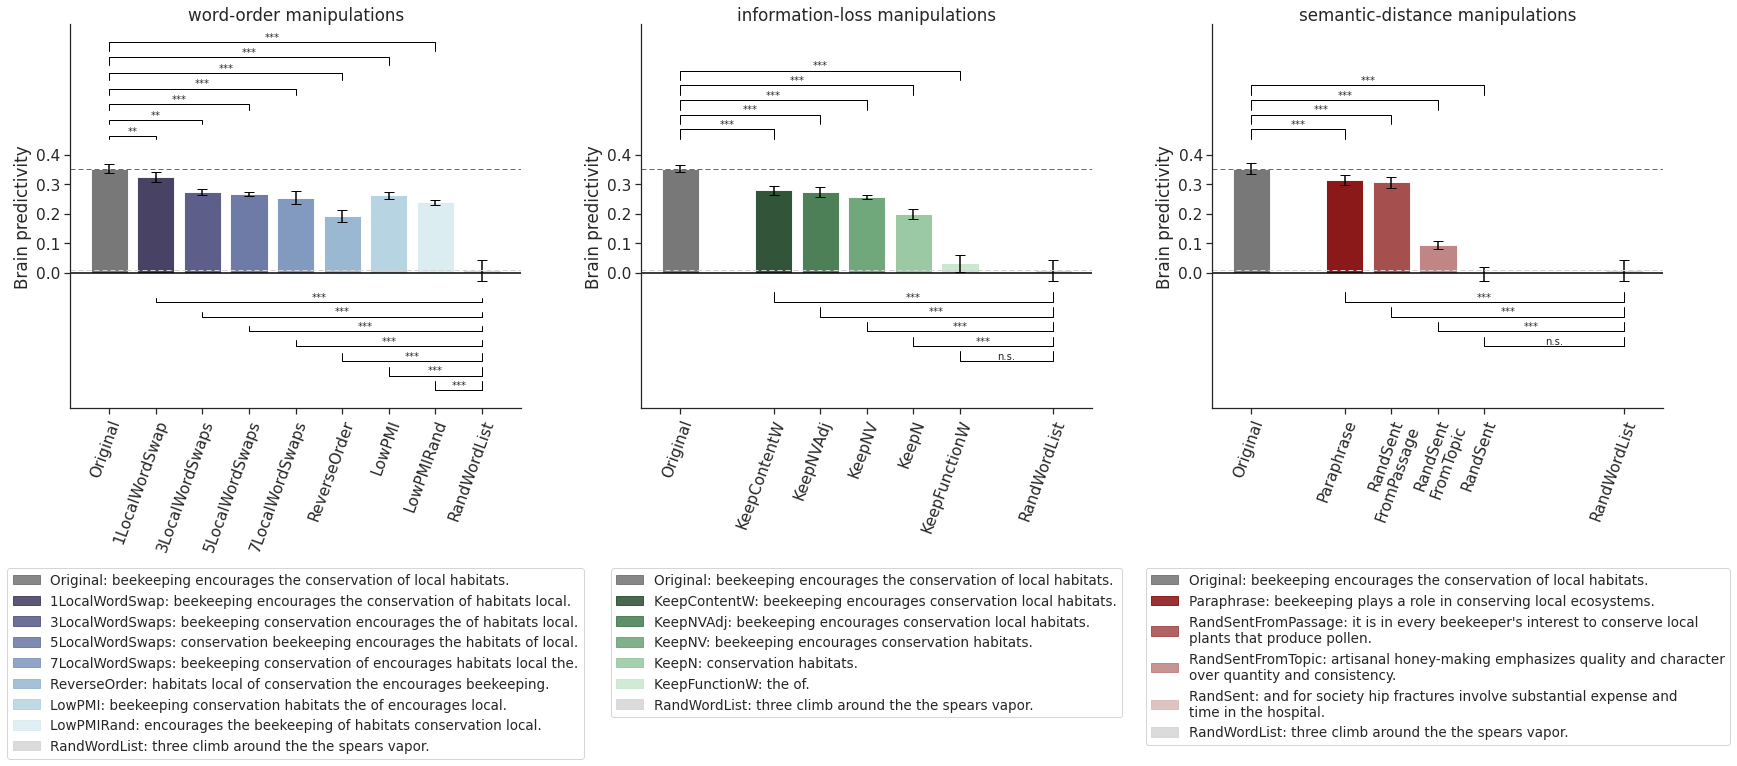

In [22]:
import math

categories = ["word-order", "information-loss", "semantic-distance"]
if randomnouns:
    categories = ["information-loss"]
if length_control:
    categories = ["control"]
    
num_bars = [len(full_df[full_df["category"] == cat]) for cat in categories]
max_bars = max(num_bars)
nrows = len(categories)

fig2 = plt.figure(constrained_layout=True, figsize=(8*nrows, 11), facecolor='white')
props = [1 + 0.2*x for x in num_bars]
spec2 = GridSpec(ncols=nrows, nrows=1, figure=fig2)
f2_ax = []

to_add = 0
    
for ind, current_category in enumerate(categories):
    #set up subplot
    if ind == 0:
        f2_ax.append(fig2.add_subplot(spec2[0, ind]))
    else:
        f2_ax.append(fig2.add_subplot(spec2[0, ind], sharey=f2_ax[0]))

    plot_df = full_df[full_df["category_group"]==current_category]
    
    if length_control:
        colors = [CAT2COLOR["original"]] + [CAT2COLOR[current_category]] + [CAT2COLOR["control"]]
    else:
        colors = [CAT2COLOR["original"]] + CAT2COLOR[current_category] + [CAT2COLOR["control"]]
    
    x_pos = np.arange(len(plot_df))
    scores = list(plot_df['score'])
    errors = list(plot_df['error'])
    conditions = list(plot_df['condition'])
                
    stimuli = [list(plot_df.loc[plot_df["category_group"] == cat]["labelname"]) for cat in categories]
    stimuli = plot_utils.flatten_list(stimuli)
    from textwrap import fill
    stimuli = [fill(l, 75) for l in stimuli]
    
    #add empty slots for same bar width
    if len(x_pos) != max_bars + 2: # +2 because of original and random-wl
        to_add = max_bars - num_bars[ind]
        x_pos = np.arange(len(plot_df) + to_add)
        multiplier1 = math.floor(to_add/2)
        multiplier2 = math.ceil(to_add/2)

        insert_at1 = 1
        insert_at2 = -1

        insert_elements1 = [np.nan]*multiplier1
        insert_elements2 = [np.nan]*multiplier2
        #
        scores[insert_at1:insert_at1] = insert_elements1
        scores[insert_at2:insert_at2] = insert_elements2
        #
        errors[insert_at1:insert_at1] = insert_elements1
        errors[insert_at2:insert_at2] = insert_elements2

        insert_elements1 = [""]*multiplier1
        insert_elements2 = [""]*multiplier2
        #
        conditions[insert_at1:insert_at1] = insert_elements1
        conditions[insert_at2:insert_at2] = insert_elements2
        #
        stimuli[insert_at1:insert_at1] = insert_elements1
        stimuli[insert_at2:insert_at2] = insert_elements2

        insert_elements1 = ["white"]*multiplier1
        insert_elements2 = ["white"]*multiplier2
        
        colors[insert_at1:insert_at1] = insert_elements1
        colors[insert_at2:insert_at2] = insert_elements2

    f2_ax[-1].bar(x_pos, scores,
        yerr=errors,
        align='center',
        alpha=0.9, #color intensity
        ecolor='black',
        capsize=5, #error-bar width
        color=colors)
    
    CAT2COND, COND2CAT = plot_utils.get_conditions(randomnouns=randomnouns, length_control=length_control)
    
    #annotate stats 2 original
    for ind_c, cond in enumerate(CAT2COND[current_category]):
        #adjust names for consistency
        if cond == 'sentenceshuffle_random':
            cond = 'sent_random'
        elif cond == 'sentenceshuffle_passage':
            cond = 'sent_passage'
        elif cond == 'sentenceshuffle_topic':
            cond = 'sent_topic'
            
        cond = plot_utils.COND2LABEL[cond]
            
        if cond in ["Original", "RandWordList"]:
            continue

        idx_random = conditions.index("RandWordList") - to_add

        positions = [i for i, score in enumerate(scores) if not np.isnan(score)]
        #print(positions)
        
        #add stats annotations for comparison with original score
        heights = [scores[0]] * len(positions)
        #add height offset to annotations
        height_offset = [0.05 * i for i in range(len(heights))]
        heights = [sum(x) for x in zip(heights, height_offset)]
        label = full_stats_df.loc[full_stats_df["condition"] == cond]["significance2original"].item()
        stats_utils.barplot_annotate_brackets(0, ind_c+1, data=label, center=positions, height=heights, fs=10)
        
        #add stats annotations for comparison with random-wl score
        heights = [0] * len(positions)
        #add height offset to annotations
        height_offset = [-0.05 * i for i in range(len(heights))]
        heights = [sum(x) for x in zip(heights, height_offset)]
        label = full_stats_df.loc[full_stats_df["condition"] == cond]["significance2random"].item()
        stats_utils.barplot_annotate_brackets(ind_c+1, idx_random, data=label, center=positions, height=heights,
                                             updown="down", fs=10)
    
    #add horizontal lines for original and random-wl
    orig_score = plot_df[plot_df["condition"]=="Original"]["score"].item()
    random_score = plot_df[plot_df["condition"]=="RandWordList"]["score"].item()
    f2_ax[-1].axhline(y=orig_score, color=CAT2COLOR["original"], linestyle=':', dashes=(5, 3), linewidth=1)
    f2_ax[-1].axhline(y=random_score, color=CAT2COLOR["control"], linestyle=":", dashes=(5, 3), linewidth=1)
    
    f2_ax[-1].axhline(y=0, color="black")

    # add legend (sample stimuli)
    # map names to colors
    cmap = dict(zip(conditions, colors))
    cmap = {k: v for k, v in cmap.items() if k}
    # create the rectangles for the legend
    from matplotlib.patches import Patch
    patches = [Patch(color=v, label=k, alpha=0.8) for k, v in cmap.items()]
    # remove empty strings from labels
    stimuli = [x for x in stimuli if x]
    # add the legend
    f2_ax[-1].legend(title='', labels=stimuli, handles=patches,
                     loc='upper center', bbox_to_anchor=(0.5, -0.4),
                     title_fontsize=15, prop={'size': 13.5})

    
    # TICKS
    ## to get current ones: f2_ax[-1].get_yticks()
    if ind == 0:
        yticks = [0, 0.1, 0.2, 0.3, 0.4]
        f2_ax[-1].set_yticks(yticks)
    #set yticks
    f2_ax[-1].set_xticks(positions)
    xticknames = ["\nFrom".join(elm.split("From")) for elm in conditions]
    f2_ax[-1].set_xticklabels([x for x in xticknames if x], rotation=70, ha="right", rotation_mode="anchor")
    
    f2_ax[-1].set_ylabel('Brain predictivity')
    
    f2_ax[-1].set_title(f"{current_category} manipulations",pad=0.5)

    plt.tight_layout()

save=True
if save:
    if not (randomnouns or length_control):
        plt.savefig(f'results_paper_revision/SupplementaryInformation/{approach}_BESTINTACTLAYER.svg', dpi=180)
        plt.savefig(f'results_paper_revision/SupplementaryInformation/{approach}_BESTINTACTLAYER.png', dpi=180, bbox_inches='tight')